In [49]:
import os
import numpy as np  
import pandas as pd 
import statsmodels as sm 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker    
import seaborn as sns    
import pdfplumber

import scipy.stats as stats
from scipy.sparse import csr_matrix

### Load and Clean Data

In this section we extract the dance scores from multiple data tables in a pdf document. Then we apply some basic transformations to make the data easier to work with and perform some quality checks. 

In [3]:
pdf_path = "/Users/alexanderbarriga/my_portfolio/Argentine_Tango_Mundial/Data/Ranking-Clasificatoria-Tango-de-Pista-Mundial-de-tango-2024.pdf"
data_to_csv = '../Data/Ranking-Clasificatoria-Tango-de-Pista-Mundial-de-tango-2024.csv'

In [4]:
def extract_tables_from_pdf():
    with pdfplumber.open(pdf_path) as pdf:
        lst = [p.extract_table() for p in pdf.pages]
    
    flat_list = [item for sublist in lst for item in sublist]
    df = pd.DataFrame(flat_list)
    df.columns = df.iloc[0]
    df = df[1:]

    # not every judge scored every dance couple, fill missing values 
    df.replace('', None, inplace=True)
    df.to_csv(data_to_csv)
    return df

#df = extract_tables_from_pdf()

# load data
df = pd.read_csv(data_to_csv).drop('Unnamed: 0', axis=1)

# need to rename the overloaded name features 
new_cols = [
       'PAREJA', 'Nombre_del_Pareja_Hombre', 'Nombre_del_Pareja_Mujer', 'Jimena_Hoffner',
       'Silvina_Valz', 'Gaston_Torelli', 'Martin_Ojeda', 'Laura_Melo',
       'Graciela_Gonzalez', 'Aoniken_Quiroga', 'Paola_Tachetti',
       'Facundo_de_la_Cruz', 'Stella_Baez', 'Agustin_Agnez',
       'Magdalena_Gutierrez', 'Lucas_Paez', 'Roberto_Zuccarino',
       'Analia_Vega', 'Dante_Sanchez', 'Carlos_Stasi', 'Mariana_Dragone',
       'Monica_Matera', 'Noelia_Barsi', 'PROMEDIO'
       ]
df.columns = new_cols

# move couple number and names to index 
df = df.set_index(['PAREJA', 'Nombre_del_Pareja_Hombre', 'Nombre_del_Pareja_Mujer'])

# this feature set only contains the scores given to the dancers by the judges
judge_features = [
    'Jimena_Hoffner',
    'Silvina_Valz', 'Gaston_Torelli', 'Martin_Ojeda', 'Laura_Melo',
    'Graciela_Gonzalez', 'Aoniken_Quiroga', 'Paola_Tachetti',
    'Facundo_de_la_Cruz', 'Stella_Baez', 'Agustin_Agnez',
    'Magdalena_Gutierrez', 'Lucas_Paez', 'Roberto_Zuccarino',
    'Analia_Vega', 'Dante_Sanchez', 'Carlos_Stasi', 'Mariana_Dragone',
    'Monica_Matera', 'Noelia_Barsi'   
]

df = df.apply(pd.to_numeric, errors='coerce')


In [5]:
# these cell values are from the table headers from page 2 onwards
df.PROMEDIO[df.PROMEDIO.isnull()]

PAREJA  Nombre_del_Pareja_Hombre  Nombre_del_Pareja_Mujer
PAREJA  Nombre y Apellido         Nombre y Apellido         NaN
                                  Nombre y Apellido         NaN
                                  Nombre y Apellido         NaN
                                  Nombre y Apellido         NaN
                                  Nombre y Apellido         NaN
                                  Nombre y Apellido         NaN
                                  Nombre y Apellido         NaN
                                  Nombre y Apellido         NaN
Name: PROMEDIO, dtype: float64

In [6]:
not_null = ~df.PROMEDIO.isnull()
df = df[not_null] # remove page 2 and onward table headers 

In [7]:
# TODO: 
# calculate each judge's scoring bias
# adjust their scores accordingly 
# perform statistical tests on whether or not each judge's scoring is different from the other judges
# determine if some couples get an unfair advantage by getting scored by some judges over others
# calculate if the different between the judging bias was enough to boost people into the semi-final round 
# ... or if they would have landed there no matter the panel of judges
df.head()

,,,Jimena_Hoffner,Silvina_Valz,Gaston_Torelli,Martin_Ojeda,Laura_Melo,Graciela_Gonzalez,Aoniken_Quiroga,Paola_Tachetti,Facundo_de_la_Cruz,Stella_Baez,...,Magdalena_Gutierrez,Lucas_Paez,Roberto_Zuccarino,Analia_Vega,Dante_Sanchez,Carlos_Stasi,Mariana_Dragone,Monica_Matera,Noelia_Barsi,PROMEDIO
PAREJA,Nombre_del_Pareja_Hombre,Nombre_del_Pareja_Mujer,,,,,,,,,,,,,,,,,,,,,
67,Dmitrii Liferov,Dana Son,NaN,NaN,NaN,NaN,NaN,8.0,7.85,7.30,8.00,7.85,...,NaN,NaN,NaN,NaN,7.30,8.00,8.0,8.00,7.9,7.820
466,Ariel Taritolay,Laura Casco Zorzón,NaN,NaN,NaN,NaN,NaN,7.6,7.30,7.30,7.65,7.55,...,NaN,NaN,NaN,NaN,7.30,7.70,8.0,7.90,8.0,7.630
438,Leonardo Salvador Guerra,Noelia Romina Andino,NaN,NaN,NaN,NaN,NaN,8.0,7.40,7.90,6.80,7.45,...,NaN,NaN,NaN,NaN,7.40,7.80,7.5,8.00,7.9,7.615
24,Ramiro Nicolas Almiron,Lali Torres,NaN,NaN,NaN,NaN,NaN,7.9,7.55,7.40,7.80,7.60,...,NaN,NaN,NaN,NaN,7.45,7.55,7.2,7.55,7.9,7.590
8,Erik Deslarmes,Nadia Aguilar,NaN,NaN,NaN,NaN,NaN,7.9,7.30,7.15,8.00,7.40,...,NaN,NaN,NaN,NaN,7.85,7.60,7.3,7.60,7.8,7.590


### Data Visualizations 

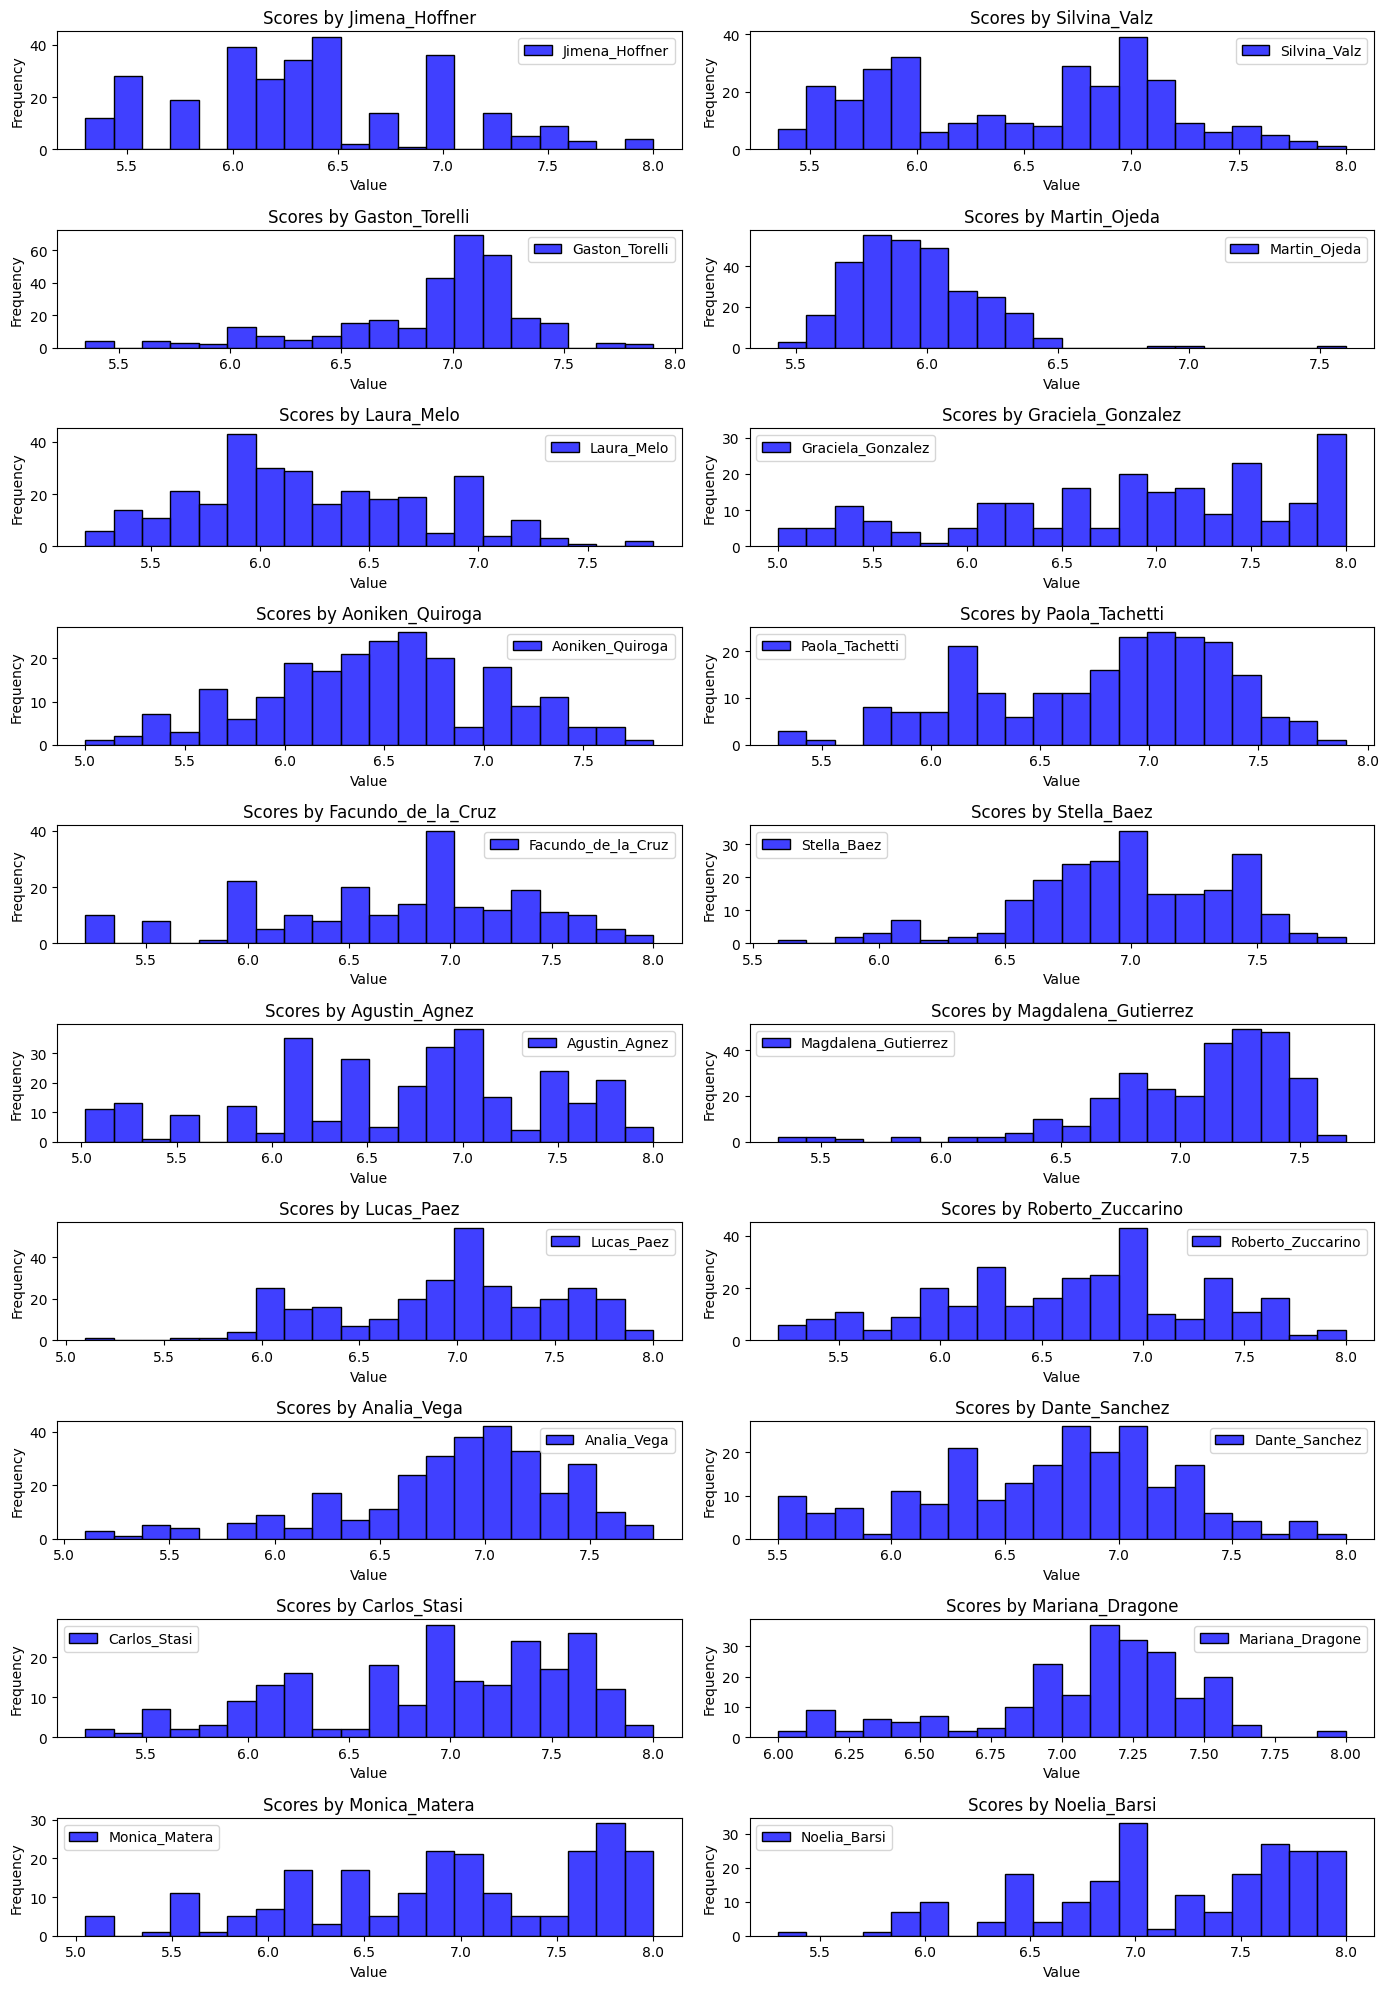

In [8]:
# TODO: demonstrate the the CLT is taking place here
# Check if dists are normal (I expect that not all are)
# Even so, the distribution of their means is normal 
# Include Normal=True/False in the title or legend 

# Set up the subplot grid
fig, axes = plt.subplots(10, 2, figsize=(14, 20))  # Adjust size as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature's histogram in the respective subplot
for i, feature in enumerate(judge_features):
    sns.histplot(df[feature], kde=False, ax=axes[i], color='blue', bins=20, label=feature)
    axes[i].set_title(f'Scores by {feature}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

The above histograms show the distribution of scores that each judge gave to each dance couple that they score. We can see that each judge has their own scoring bias. Some are biased toward giving a score around 6 others around 7 and the variance between distributions vary widely as well. 

 Note that not all judges scored all dance couples. There are 20 judges and each dance couple was score by 10 judges. This means that not every dance couple was exposed to each judge's scoring bias. A potential concern here is that a subset of couples might have been score more harshly than another subset of couples, if so there are two additional concerns. 
1) It can make an objective comparison between dance couple performance difficult to obtain. 
2) it could make the difference between qualifying and not qualifying for the semi-final round for a few couples that scored on the edge of qualification. 

In order to answer these two questions, we are going to throw a battery of statistic tests and methods to investigate any potential scoring bias, correct for it, and re-rank our competitors and see if removing judging bias actually has any meaningful consequences, such as on those edge case couples mention in concern (2). 

### Test each Judge's Score Distribution for Normality 

- Only 1 judge has a distribution of scores for which there is statistical evidence of being normal. 
- Most judges have normality in the mid-range of values but not in the tail ends of their score distribution 
- Interestingly, the average of the scores column is also not statistically normal. 

In [ ]:
# Function to perform Shapiro-Wilk test
def shapiro_test(data):
    """Perform Shapiro-Wilk test for normality."""
    stat, p_value = stats.shapiro(data, nan_policy='omit')
    return stat, p_value

# Function to create QQ plot with Shapiro-Wilk results in the title
def qq_plot(data, feature_name, is_normal, p_value):
    """Create QQ plot for a given feature with Shapiro-Wilk results in the title."""
    plt.figure(figsize=(8, 6))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ Plot of {feature_name}\n'
              f'Shapiro-Wilk Test: Normal = {is_normal}, p-value = {p_value:.4f}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid(True)
    plt.show()


# Dictionary to store Shapiro-Wilk test results
shapiro_results = {}

# Perform Shapiro-Wilk test and plot QQ plots for each feature
for feature in df.columns:
    feature_data = df[feature].dropna()  # Drop missing values if any
    stat, p_value = shapiro_test(feature_data)
    
    
    if p_value < 0.05:
        is_normal=False
    else:
        is_normal=True
    
    # Store results
    shapiro_results[feature] = (stat, p_value)
    
    # Create QQ plot with test results in the title
    qq_plot(feature_data, feature, is_normal, p_value)# Plot each feature's histogram in the respective subplot

### Test Each Judge's Mean Score to see if it is Statistically Different from the Mean Score of Their Peers 

#### First Define the Reference Distribution 

- Take the mean score of all 20 judges, the resulting distribution is the mean scores of all the judges. 
- We are going to sample and test if there is statistical evidence of each individual judge mean belonging to the distribution 


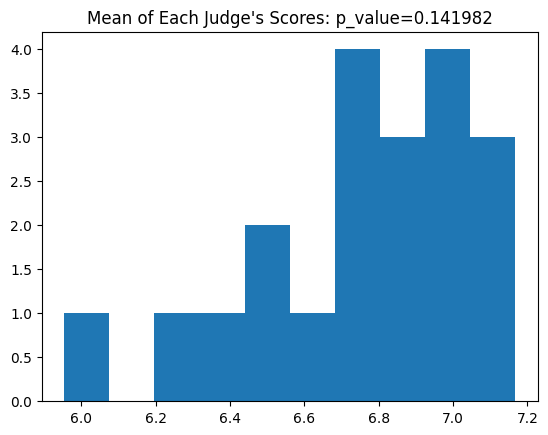

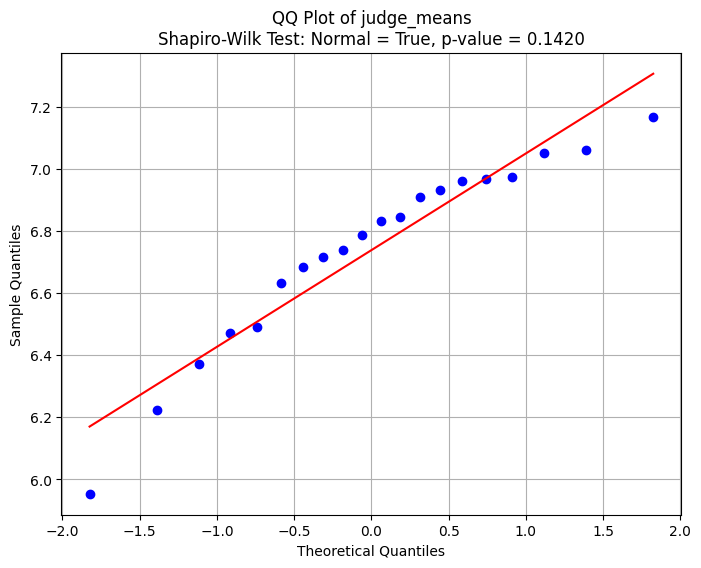

In [10]:
# most judges give a mean score between 6.4 and 7.0` is providing information about the typical range of mean scores given by judges. It suggests that the majority of judges tend to give mean scores within the range of 6.4 to 7.0. This information is relevant for understanding the distribution and tendencies of judge scores in the dataset being analyzed.
# most judges give a mean score between 6.4 and 7.0
# this distribution is statistically normal 
# this is our reference distribution 
judge_means = df[judge_features].mean()
stat, p_value = shapiro_test(judge_means)
plt.title(f"Mean of Each Judge's Scores: p_value={p_value:3f}")
plt.hist(judge_means);

qq_plot(judge_means, "judge_means", True, p_value)

In [11]:
judge_means.describe()

count    20.000000
mean      6.738136
std       0.307254
min       5.953885
25%       6.597161
50%       6.808824
75%       6.960955
max       7.167273
dtype: float64

#### Perform the Statistical Test on Each Judge's Mean Score

In [12]:
# Calculate mean and standard deviation of the distribution of mean scores
distribution_mean = np.mean(judge_means)
distribution_std = np.std(judge_means, ddof=1)

# Function to perform T-test
def t_test(score, mean, std_dev, n):
    """Perform a T-test to check if a score is significantly different from the mean."""
    t_value = (score - mean) / (std_dev / np.sqrt(n))
    # Degrees of freedom for the T-test
    df = n - 1
    # Two-tailed test
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_value), df))
    return t_value, p_value

# Number of samples in the distribution
n = len(judge_means)

# Dictionary to store the test results
results = {}

# Iterate through each judge's mean score and perform T-test
for judge, score in zip(judge_features, judge_means):
    t_value, p_value = t_test(score, distribution_mean, distribution_std, n)
    
    # Store results in the dictionary
    results[judge] = {
        'mean_score': score,
        'T-Value': t_value,
        'P-Value': p_value,
        'Significant': p_value < 0.05
    }

# Convert results to DataFrame and process
df_judge_means_test = pd.DataFrame(results).T
df_judge_means_test.mean_score = df_judge_means_test.mean_score.astype(float)
df_judge_means_test.sort_values('mean_score')

,mean_score,T-Value,P-Value,Significant
Martin_Ojeda,5.953885,-11.41493,0.0,True
Laura_Melo,6.222466,-7.505679,0.0,True
Jimena_Hoffner,6.372586,-5.320652,0.000039,True
Aoniken_Quiroga,6.470769,-3.891579,0.000982,True
Silvina_Valz,6.490000,-3.611671,0.001858,True
Roberto_Zuccarino,6.632881,-1.532005,0.142003,False
Dante_Sanchez,6.684091,-0.786639,0.441195,False
Agustin_Agnez,6.715932,-0.323183,0.750086,False
Facundo_de_la_Cruz,6.739231,0.015932,0.987455,False
Paola_Tachetti,6.785520,0.689686,0.498729,False


#### Interpretation 

Plots 
- The Shapiro test provides evidence that the distribution of judge mean scores is statistically normal. 
- The QQ plot shows us that there appears to be some deviation from normality at the tail ends 

The T-test tested if each judge's mean score is statistically likely to have occurred from the same distribution of all judge mean scores with a mean of 6.738
- Judges with a mean score of 6.6 through 6.8 are statistically likely to have been sampled from a distribution with a mean of 6.738
- Judges with mean scores outside of that range, on either sides, are statistically unlikely to have been sampled from a distribution with a mean of 6.738

What does this tell us about the judges themselves?
- Most judges give a mean score that is atypical of the collective mean among their peers 
- Most judges give a mean score that indicates that they either score harsher than their peer's averages or more leniently than their peer's averages. 

Let's take another look at three distributions: of `Martin_Ojeda` the harshest judge, of `Facundo_de_la_Cruz` the most typical judge, and `Noelia_Barsi` the most lenient judge. 

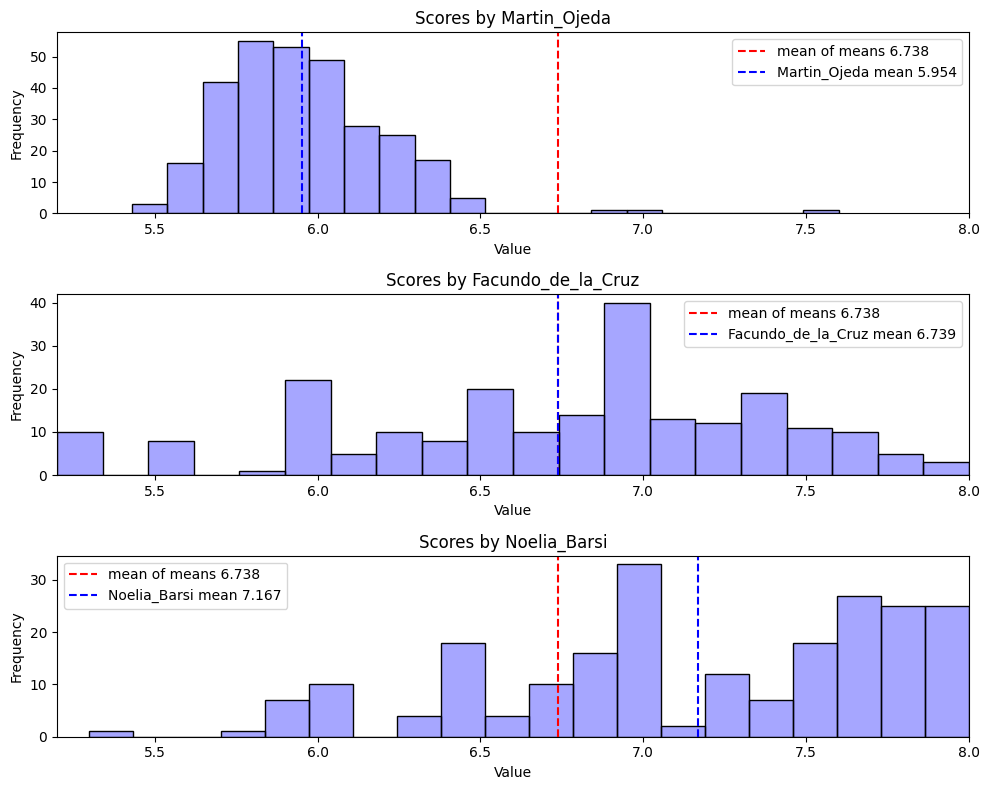

In [13]:
judges_subset=['Martin_Ojeda', 'Facundo_de_la_Cruz', 'Noelia_Barsi']

# Set up the subplot grid
fig, axes = plt.subplots(3, 1, figsize=(10, 8))  # Adjust size as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define the value for the dashed vertical line
mean_of_means = 6.738

x_max = df[judges_subset].max().max()
x_min = df[judges_subset].min().min()

# Plot each feature's histogram in the respective subplot
for i, feature in enumerate(judges_subset):
    mean = df_judge_means_test.loc[feature, 'mean_score']
    sns.histplot(df[feature], kde=False, ax=axes[i], color='blue', bins=20, alpha=0.35)
    axes[i].axvline(mean_of_means, color='red', linestyle='--', label='mean of means {}'.format(mean_of_means))
    axes[i].axvline(mean, color='blue', linestyle='--', label=feature + " mean {:.4}".format(mean))
    axes[i].set_title(f'Scores by {feature}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].set_xlim(x_min, x_max)

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
df[judges_subset].describe()

,Martin_Ojeda,Facundo_de_la_Cruz,Noelia_Barsi
count,296.000000,221.000000,220.000000
mean,5.953885,6.739231,7.167273
std,0.248749,0.651186,0.611045
min,5.430000,5.200000,5.300000
25%,5.790000,6.300000,6.775000
50%,5.920000,6.900000,7.300000
75%,6.090000,7.250000,7.700000
max,7.600000,8.000000,8.000000


- We can see that `Martin_Ojeda` is the harshest judge but is very consist in his scoring as indicated by the standard deviation. 
- While `Facundo_de_la_Cruz` and `Noelia_Barsi` have a standard deviation about 3 times as large as `Martin_Ojeda` indicating a lot of variance in their judgments. 

Given that `Martin_Ojeda` is the harshest judge with the vast majority of scores below 6.6, it interesting to see that he gave a couple a score slightly above 7.5 which is certainly an outlier score. 



In [15]:
# here we see that Lucas Cartagena & Lucila Diaz Colodrero stood out in the eyes of Martin_Ojeda as exceptional dancers 
df['Martin_Ojeda'].sort_values(ascending=False).dropna()

PAREJA  Nombre_del_Pareja_Hombre  Nombre_del_Pareja_Mujer
64      Lucas Cartagena           Lucila Diaz Colodrero      7.60
112     Dario Artunduaga          Anastasiia Rudiak          7.00
589     Froyamel Corro            Magdalena Benitez          6.85
181     Alexander Moncada Rojas   Martina Waldman            6.50
154     Facundo Barrionuevo       Agustina Juanbelz          6.49
                                                             ... 
121     Augusto Testa             Maia Duek                  5.59
26      Leo Park                  Dulce Lee                  5.56
45      Jose Hidalgo              Assa Witkov                5.50
161     Peter Brody               Azul Martinez              5.45
65      Manoj Unni                Shreya Shah                5.43
Name: Martin_Ojeda, Length: 296, dtype: float64

## Panel Biases 

In this section we will look at Rank-based and Mean-based panel biases. 

### Rank-Based Panel Biases 

Here we will rank and standardize the judge mean scores and calculate a bias for each panel. This is one way in which we can measure any potential biases that exist between judge panels. 

In [101]:
df_judge_means = df_judge_means_test.sort_values('mean_score').mean_score

# Calculate ranks
ranks = df_judge_means.rank()

# Calculate mean and std of ranks
means_ranks = ranks.mean()
stds_ranks = ranks.std()

# Standardize ranks
df_judge_ranks = (ranks - means_ranks) / stds_ranks
df_judge_ranks
# these are the same judges sorted in the same way as before based on their mean scores
# except here we have converted mean values into rankings and standardized the rankings 
# Now we want to see how these 20 judges are distributed between the two panels 
# do the biases for each judge get canceled out by their peers on the same panel?

Martin_Ojeda          -1.605793
Laura_Melo            -1.436762
Jimena_Hoffner        -1.267731
Aoniken_Quiroga       -1.098701
Silvina_Valz          -0.929670
Roberto_Zuccarino     -0.760639
Dante_Sanchez         -0.591608
Agustin_Agnez         -0.422577
Facundo_de_la_Cruz    -0.253546
Paola_Tachetti        -0.084515
Graciela_Gonzalez      0.084515
Analia_Vega            0.253546
Gaston_Torelli         0.422577
Carlos_Stasi           0.591608
Monica_Matera          0.760639
Lucas_Paez             0.929670
Stella_Baez            1.098701
Mariana_Dragone        1.267731
Magdalena_Gutierrez    1.436762
Noelia_Barsi           1.605793
Name: mean_score, dtype: float64

In [98]:
# panel 1 judges 
df_judge_ranks[panel_1].sort_values()

Martin_Ojeda          -1.605793
Laura_Melo            -1.436762
Jimena_Hoffner        -1.267731
Silvina_Valz          -0.929670
Roberto_Zuccarino     -0.760639
Agustin_Agnez         -0.422577
Analia_Vega            0.253546
Gaston_Torelli         0.422577
Lucas_Paez             0.929670
Magdalena_Gutierrez    1.436762
Name: mean_score, dtype: float64

In [99]:
# panel 2 judges 
df_judge_ranks[panel_2].sort_values()

Aoniken_Quiroga      -1.098701
Dante_Sanchez        -0.591608
Facundo_de_la_Cruz   -0.253546
Paola_Tachetti       -0.084515
Graciela_Gonzalez     0.084515
Carlos_Stasi          0.591608
Monica_Matera         0.760639
Stella_Baez           1.098701
Mariana_Dragone       1.267731
Noelia_Barsi          1.605793
Name: mean_score, dtype: float64

In [96]:
df_judge_ranks[panel_1].sum(), df_judge_ranks[panel_1].mean()

(np.float64(-3.3806170189140667), np.float64(-0.33806170189140666))

In [97]:
df_judge_ranks[panel_2].sum(), df_judge_ranks[panel_2].mean()

(np.float64(3.3806170189140663), np.float64(0.3380617018914066))

### Interpretation 

Above we have the sum and mean, respectively, of each panel's rankings. 
- We can see that panel 1 is has a negative biased, indicating that panel 1 scores harshly 
- We can see that panel 2 has a positive bias, indicating that panel 2 scores leniently 

This provides evidence that competitors who are scored by panel 2 have a clear advantage to proceeding to the semi-final round over those who are scored by panel 1. 

### Mean-Based Panel Biases 

Here we will standardize the judge mean scores and calculate a bias for each panel. This is one way in which we can measure any potential biases that exist between judge panels. 

In [106]:
# Calculate mean and std 
means = df_judge_means.mean()
stds= df_judge_means.std()

# Standardize 
df_judge_means_stand = (df_judge_means - means) / stds
df_judge_means_stand


Martin_Ojeda          -2.552456
Laura_Melo            -1.678321
Jimena_Hoffner        -1.189734
Aoniken_Quiroga       -0.870184
Silvina_Valz          -0.807594
Roberto_Zuccarino     -0.342567
Dante_Sanchez         -0.175898
Agustin_Agnez         -0.072266
Facundo_de_la_Cruz     0.003563
Paola_Tachetti         0.154219
Graciela_Gonzalez      0.305905
Analia_Vega            0.349183
Gaston_Torelli         0.554847
Carlos_Stasi           0.625927
Monica_Matera          0.719868
Lucas_Paez             0.741174
Stella_Baez            0.766857
Mariana_Dragone        1.020923
Magdalena_Gutierrez    1.049868
Noelia_Barsi           1.396686
Name: mean_score, dtype: float64

In [107]:
# panel 1 judges 
df_judge_means_stand[panel_1].sort_values()

Martin_Ojeda          -2.552456
Laura_Melo            -1.678321
Jimena_Hoffner        -1.189734
Silvina_Valz          -0.807594
Roberto_Zuccarino     -0.342567
Agustin_Agnez         -0.072266
Analia_Vega            0.349183
Gaston_Torelli         0.554847
Lucas_Paez             0.741174
Magdalena_Gutierrez    1.049868
Name: mean_score, dtype: float64

In [108]:
# panel 2 judges 
df_judge_means_stand[panel_2].sort_values()

Aoniken_Quiroga      -0.870184
Dante_Sanchez        -0.175898
Facundo_de_la_Cruz    0.003563
Paola_Tachetti        0.154219
Graciela_Gonzalez     0.305905
Carlos_Stasi          0.625927
Monica_Matera         0.719868
Stella_Baez           0.766857
Mariana_Dragone       1.020923
Noelia_Barsi          1.396686
Name: mean_score, dtype: float64

In [111]:
df_judge_means_stand[panel_1].sum(), df_judge_means_stand[panel_1].mean()

(np.float64(-3.9478659591285883), np.float64(-0.3947865959128588))

In [112]:
df_judge_means_stand[panel_2].sum(), df_judge_means_stand[panel_2].mean()

(np.float64(3.947865959128635), np.float64(0.39478659591286347))

### Interpretation 

Here we see that each panel does have a bias in their scoring of dance couples
- Panel 1 has a bias on each dance couple's score of -0.3947
- Panel 2 has a bias on each dance couple's score of 0.3947 

A increase or decrease of 0.3947 in a dance couple's score represents a very large and consequential difference. The difference between qualifying and not qualifying for the semi-final round in Mundial de Tango 2024 is as small as 0.003 

 A positive mean Z-score for a panel suggests that the judges in that panel, on average, score higher than the overall mean, while a negative mean Z-score suggests they score lower.

## Distribution of Judges per Dance Couple 

1) What is the distribution of judges for each dance couple?
2) Do dance couples get pair with judge panels were judge scoring biases get cancelled out my other judges?
3) Do some dance couples get a harsher judge panel while others can a more leniently panel?

In [115]:
panel_1 = judge_features[:5] + judge_features[10:15]
panel_2 = judge_features[5:10] + judge_features[15:]
panel_1_mean_scores = df_judge_means_test.loc[panel_1,:].mean_score
panel_2_mean_scores = df_judge_means_test.loc[panel_2,:].mean_score

In [116]:
panel_1_mean_scores.describe()

count    10.000000
mean      6.616837
std       0.355448
min       5.953885
25%       6.401940
50%       6.674407
75%       6.892817
max       7.060712
Name: mean_score, dtype: float64

In [117]:
panel_2_mean_scores.describe()

count    10.000000
mean      6.859436
std       0.200646
min       6.470769
25%       6.750803
50%       6.881291
75%       6.970146
max       7.167273
Name: mean_score, dtype: float64

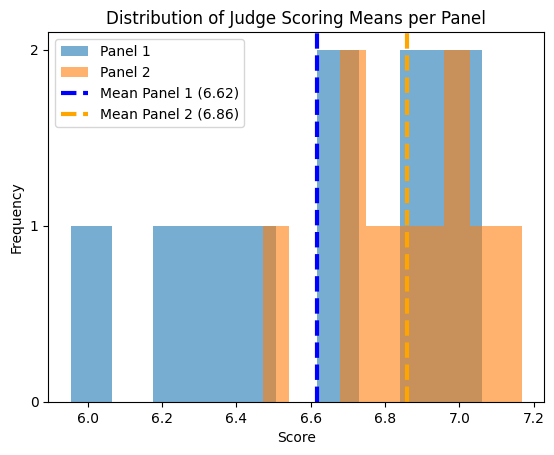

In [118]:
# Calculate means of the distributions
mean_panel_1 = sum(panel_1_mean_scores) / len(panel_1_mean_scores)
mean_panel_2 = sum(panel_2_mean_scores) / len(panel_2_mean_scores)

# Plot histograms
plt.hist(panel_1_mean_scores, alpha=0.6, label="Panel 1", bins=10)
plt.hist(panel_2_mean_scores, alpha=0.6, label="Panel 2", bins=10)

# Add vertical lines for means
plt.axvline(mean_panel_1, color='blue', linestyle='dashed', linewidth=3, label=f'Mean Panel 1 ({mean_panel_1:.2f})')
plt.axvline(mean_panel_2, color='orange', linestyle='dashed', linewidth=3, label=f'Mean Panel 2 ({mean_panel_2:.2f})')

# Add titles and labels
plt.title("Distribution of Judge Scoring Means per Panel")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()

# Set y-axis to integer values
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show plot
plt.show()

In [119]:
# Perform Welch's t-test
t_stat, p_value = stats.ttest_ind(panel_1_mean_scores, panel_2_mean_scores, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The means of the two distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to say the means of the two distributions are different.")

T-statistic: -1.8795
P-value: 0.0808
Fail to reject the null hypothesis: There is not enough evidence to say the means of the two distributions are different.


### Interpretation 

Plots 
- The distribution of mean scores that the judges on panel 2 give is noticeably higher than the distribution of mean scores that panel 1 give. 
- The difference in their means is 0.24 
- It appears from the plots that the distributions should be statistically different from one and another 

Statistical Test 
- The T-test provides no evidence that the means score between panel 1 and panel 2 are statistically different 
- This means that there is no statistical evidence that a dance couple would be positively or negatively affected by being scored by panel 1 or panel 2 
- I.E. it should matter which panel you are scored by 

#### Inconsistency Between the Z-score analysis and T-test 
An inconsistency arises between the Z-score analysis and t-test because they are measuring different aspects of scoring bias. The Z-scores standardize scores relative to all judges and capture relative deviation, while the t-test compares raw means to see if they are significantly different.

- The Z-score analysis normalizes scores to unit variance and zero mean across all judges, which means it captures relative scoring tendencies rather than absolute differences in mean scores.

- The t-test is based on raw mean scores of the panels and tests whether the observed differences in these scores are statistically significant.

Small Sample Size: 
- With only 10 judges per panel, the t-test results might be affected by sample variability, and small sample sizes can make it harder to detect significant differences even if they exist.
- Z-Score Sensitivity: Z-scores are less sensitive to small sample sizes because they standardize scores relative to the overall distribution, but they still do not account for potential systematic differences between panels beyond deviation from the overall mean.

## Test the Proportion of Dancers Advancing to Semi-Finals by Panel 

- By simply looking at the tabular data in the PDF it appears that most semi-finalist dance couples were scored by panel 2. 
- Is there a large difference in the proportions of semi-finalist between panel 1 and panel 2?
- Is there a statistically significant difference between proportion of semi-finalist between panel 1 and panel 2?

In [25]:
min_score_for_semi_finals = 7.040
is_semi_finalist = df.PROMEDIO >= min_score_for_semi_finals

successes_1 = df[is_semi_finalist][panel_1].dropna(axis=0).shape[0]  # Number of couples scored by panel 1 advancing to semi-finals
successes_2 = df[is_semi_finalist][panel_2].dropna(axis=0).shape[0] # Number of couples scored by panel 2 advancing to semi-finals

n1 = df[panel_1].dropna(axis=0).shape[0] # Total number of couples that where scored by panel 1 
n2 = df[panel_2].dropna(axis=0).shape[0] # Total sample of couples that where scored by panel 2 

In [26]:
successes_1, successes_2, n1, n2

(49, 93, 287, 218)

In [27]:
successes_1/n1, successes_2/n2

(0.17073170731707318, 0.42660550458715596)

- We see of the dancers that advanced to the semi-final round by panel 1 is 17% and by panel 2 is 42%
- Panel 2 advanced more than double the proportion of dancers than panel 1 


We are going to perform a Two-Tailed Test for Equality between Two Population Proportions 

- The two-tailed z-test is used when you want to test if there is a significant difference between the two proportions in either direction. 
- In other words, you are interested in whether one proportion is significantly different from the other, regardless of whether it is larger or smaller.

Z-Value: -6.3350
P-Value: 0.0000
The difference between the two proportions is statistically significant.


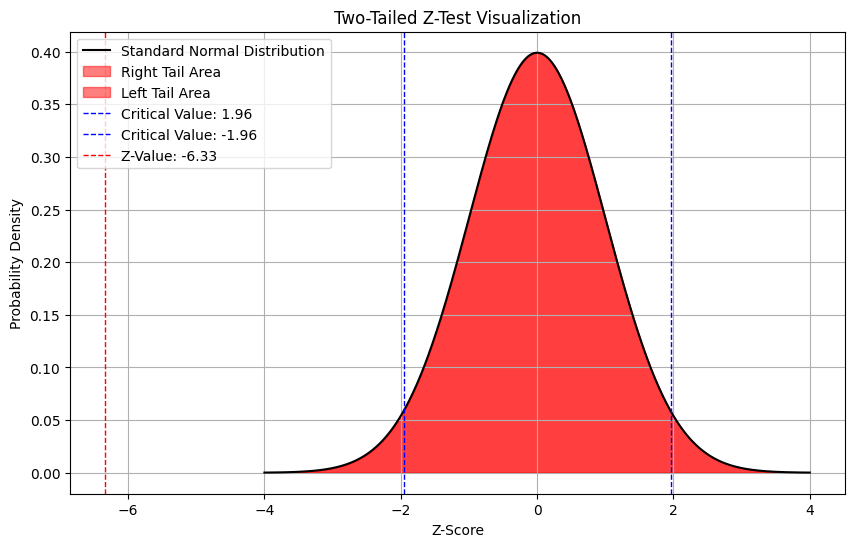

In [28]:
def plot_two_tailed_test(z_value):
    # Generate a range of x values
    x = np.linspace(-4, 4, 1000)
    # Get the standard normal distribution values for these x values
    y = stats.norm.pdf(x)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Standard Normal Distribution', color='black')
    
    # Shade the areas in both tails with red
    plt.fill_between(x, y, where=(x >= z_value), color='red', alpha=0.5, label='Right Tail Area')
    plt.fill_between(x, y, where=(x <= -z_value), color='red', alpha=0.5, label='Left Tail Area')
    
    # Define critical values for alpha = 0.05
    alpha = 0.05
    critical_value = stats.norm.ppf(1 - alpha / 2)
    
    # Add vertical dashed blue lines for critical values
    plt.axvline(critical_value, color='blue', linestyle='dashed', linewidth=1, label=f'Critical Value: {critical_value:.2f}')
    plt.axvline(-critical_value, color='blue', linestyle='dashed', linewidth=1, label=f'Critical Value: {-critical_value:.2f}')
    
    # Mark the z-value
    plt.axvline(z_value, color='red', linestyle='dashed', linewidth=1, label=f'Z-Value: {z_value:.2f}')
    
    # Add labels and title
    plt.title('Two-Tailed Z-Test Visualization')
    plt.xlabel('Z-Score')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()


def two_proportion_z_test(successes1, total1, successes2, total2):
    """
    Perform a two-proportion z-test to check if two population proportions are significantly different.

    Parameters:
    - successes1: Number of successes in the first sample
    - total1: Total number of observations in the first sample
    - successes2: Number of successes in the second sample
    - total2: Total number of observations in the second sample

    Returns:
    - z_value: The z-statistic
    - p_value: The p-value of the test
    """
    # Calculate sample proportions
    p1 = successes1 / total1
    p2 = successes2 / total2

    # Combined proportion
    p_combined = (successes1 + successes2) / (total1 + total2)

    # Standard error
    se = np.sqrt(p_combined * (1 - p_combined) * (1/total1 + 1/total2))

    # Z-value
    z_value = (p1 - p2) / se

    # P-value for two-tailed test
    p_value = 2 * (1 - stats.norm.cdf(np.abs(z_value)))
    
    return z_value, p_value


# Perform the test
z_value, p_value = two_proportion_z_test(successes_1, n1, successes_2, n2)

# Print the results
print(f"Z-Value: {z_value:.4f}")
print(f"P-Value: {p_value:.4f}")

# Check significance at alpha = 0.05
alpha = 0.05
if p_value < alpha:
    print("The difference between the two proportions is statistically significant.")
else:
    print("The difference between the two proportions is not statistically significant.")
    

# Generate the plot
plot_two_tailed_test(z_value)



#### Interpretation 
- This two-tailed test checks if our calculated Z-score leads to a p-value that is greater than or less than alpha (i.e. 0.05)
- Our calculated Z-score is lands us on the portion of the standard normal distribution where the vertical red line exists 
- That vertical red line corresponds to our p-value of 0.00000
- The vertical blue lines correspond to our statistical significance level of 0.05
- Clearly our p-value is much less than alpha and leads us to reject the null hypothesis 
- I.E. there is statistical evidence support the claim that the proportions are real and different 

The test provided enough evidence to conclude that the proportions of dancers advancing to the semi-final round between panel 1 and panel 2 are statistically different. This means that any observed difference in proportions is a true effect.



## Adjust Dancer Scores due to Bias and Re-rank 

Now that we have evidence that judge scoring bias and therefore panel mean scoring bias is present, we will apply a Mixed-Effects Models to calculate the bias from each judge, use those biases to adjust the dance scores, and re-rank the dancers. Once we re-rank the dancers, we can see if the bias correct changes which dances make it to the semi-finals and if the proportion of dances assigned to panel 1 and 2 changes who made it to the semi-final round changes as well. 

In [125]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm


In [128]:
# Generate data where each dance couple is scored by judges from only one panel
num_couples = 10
num_judges = 10
scores_per_couple = 10

# Create panel assignment
panels = np.concatenate([np.repeat('Panel 1', num_judges // 2), np.repeat('Panel 2', num_judges // 2)])
np.random.shuffle(panels)  # Shuffle to distribute panels among judges

# Generate the DataFrame
data = {
    'dance_couple_id': np.repeat(range(1, num_couples + 1), num_judges // 2),
    'judge_id': np.tile(range(1, num_judges + 1), num_couples // 2),
    'panel': np.repeat(panels, num_couples // 2),
    'score': np.random.uniform(1, 10, num_couples * (num_judges // 2))
}

pd.DataFrame(data).head(20)

,dance_couple_id,judge_id,panel,score
0,1,1,Panel 1,5.364581
1,1,2,Panel 1,7.847990
2,1,3,Panel 1,9.544238
3,1,4,Panel 1,1.591754
4,1,5,Panel 1,1.026310
5,2,6,Panel 1,6.511061
6,2,7,Panel 1,3.316015
7,2,8,Panel 1,7.405577
8,2,9,Panel 1,2.487158
9,2,10,Panel 1,3.725128


In [159]:
df_pivot = df.reset_index().drop(['Nombre_del_Pareja_Hombre', 'Nombre_del_Pareja_Mujer','PROMEDIO'], axis=1)
df_pivot = df_pivot.melt(id_vars=['PAREJA'], value_vars=judge_features).sort_values('PAREJA').rename(columns={'variable':'judge_id', 'PAREJA':'dance_couple_id', 'value':'score'})
df_pivot['panel'] = df_pivot['judge_id'].apply(lambda x: 'Panel 1' if x in panel_1 else 'Panel 2')
df_pivot.dropna(inplace=True)

In [160]:
df_pivot.head(25)

,dance_couple_id,judge_id,score,panel
5008,1,Stella_Baez,6.85,Panel 2
9652,1,Monica_Matera,7.60,Panel 2
8620,1,Carlos_Stasi,6.80,Panel 2
3460,1,Aoniken_Quiroga,6.00,Panel 2
8104,1,Dante_Sanchez,6.10,Panel 2
9136,1,Mariana_Dragone,7.00,Panel 2
4492,1,Facundo_de_la_Cruz,5.90,Panel 2
3976,1,Paola_Tachetti,6.10,Panel 2
10168,1,Noelia_Barsi,6.50,Panel 2
2944,1,Graciela_Gonzalez,5.90,Panel 2


In [174]:
df_pivot = df_pivot.groupby('dance_couple_id').apply(lambda x: x[x['panel'] == x['panel'].iloc[0]])
df_pivot

/var/folders/_b/bg10lw5s3qv87q59tkf0hsrc0000gn/T/ipykernel_17769/2339741920.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot = df_pivot.groupby('dance_couple_id').apply(lambda x: x[x['panel'] == x['panel'].iloc[0]])


dance_couple_id           judge_id  score    panel
dance_couple_id                                                        
1               5008               1        Stella_Baez   6.85  Panel 2
                9652               1      Monica_Matera   7.60  Panel 2
                8620               1       Carlos_Stasi   6.80  Panel 2
                3460               1    Aoniken_Quiroga   6.00  Panel 2
                8104               1      Dante_Sanchez   6.10  Panel 2
...                              ...                ...    ...      ...
99              6386              99         Lucas_Paez   7.70  Panel 1
                710               99       Silvina_Valz   6.95  Panel 1
                7418              99        Analia_Vega   7.20  Panel 1
                6902              99  Roberto_Zuccarino   6.20  Panel 1
                2258              99         Laura_Melo   6.98  Panel 1

[5129 rows x 4 columns]

In [175]:
# Fit a mixed-effects model
model = mixedlm("score ~ panel", df_pivot, groups=df_pivot["judge_id"], re_formula="~panel")

result = model.fit()

# Print model summary
print(result.summary())

# Extract random effects (judge biases)
random_effects = result.random_effects

# Map random effects back to judges
df_pivot['judge_bias'] = df_pivot['judge_id'].map(lambda x: random_effects.get(x, 0))

# Adjust individual scores
df_pivot['adjusted_score'] = df_pivot['score'] - df_pivot['judge_bias']


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       score     
No. Observations:       5129          Method:                   REML      
No. Groups:             20            Scale:                    0.3343    
Min. group size:        218           Log-Likelihood:           -4509.8270
Max. group size:        296           Converged:                Yes       
Mean group size:        256.4                                             
--------------------------------------------------------------------------
                             Coef.    Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                     6.617       0.112 58.900 0.000  6.397  6.837
panel[T.Panel 2]              0.240       0.129  1.861 0.063 -0.013  0.493
Group Var                     0.125       0.103                           
Group x panel[T.Panel 2] Cov -0.089 1212559.

In [179]:
df_pivot.head(55)

dance_couple_id             judge_id  score    panel  \
dance_couple_id                                                              
1               5008                1          Stella_Baez   6.85  Panel 2   
                9652                1        Monica_Matera   7.60  Panel 2   
                8620                1         Carlos_Stasi   6.80  Panel 2   
                3460                1      Aoniken_Quiroga   6.00  Panel 2   
                8104                1        Dante_Sanchez   6.10  Panel 2   
                9136                1      Mariana_Dragone   7.00  Panel 2   
                4492                1   Facundo_de_la_Cruz   5.90  Panel 2   
                3976                1       Paola_Tachetti   6.10  Panel 2   
                10168               1         Noelia_Barsi   6.50  Panel 2   
                2944                1    Graciela_Gonzalez   5.90  Panel 2   
10              7573               10          Analia_Vega   7.30  Panel 1   
                2413               10           Laura_Melo   5.80  Panel 1   
                6025               10  Magdalena_Gutierrez   7.30  Panel 1   
                6541               10           Lucas_Paez   6.11  Panel 1   
                1381               10       Gaston_Torelli   7.08  Panel 1   
                349                10       Jimena_Hoffner   6.30  Panel 1   
                5509               10        Agustin_Agnez   7.10  Panel 1   
                1897               10         Martin_Ojeda   5.87  Panel 1   
                865                10         Silvina_Valz   5.85  Panel 1   
                7057               10    Roberto_Zuccarino   6.30  Panel 1   
101             5368              101        Agustin_Agnez   6.10  Panel 1   
                1240              101       Gaston_Torelli   7.11  Panel 1   
                6916              101    Roberto_Zuccarino   7.00  Panel 1   
                724               101         Silvina_Valz   6.70  Panel 1   
                2272              101           Laura_Melo   6.60  Panel 1   
                7432              101          Analia_Vega   7.40  Panel 1   
                1756              101         Martin_Ojeda   6.01  Panel 1   
                208               101       Jimena_Hoffner   7.00  Panel 1   
                6400              101           Lucas_Paez   7.35  Panel 1   
                5884              101  Magdalena_Gutierrez   7.32  Panel 1   
102             1632              102         Martin_Ojeda   6.10  Panel 1   
                2148              102           Laura_Melo   6.95  Panel 1   
                600               102         Silvina_Valz   7.05  Panel 1   
                1116              102       Gaston_Torelli   7.46  Panel 1   
                6792              102    Roberto_Zuccarino   7.30  Panel 1   
                5760              102  Magdalena_Gutierrez   7.47  Panel 1   
                6276              102           Lucas_Paez   7.70  Panel 1   
                5244              102        Agustin_Agnez   7.60  Panel 1   
                84                102       Jimena_Hoffner   7.20  Panel 1   
                7308              102          Analia_Vega   6.95  Panel 1   
103             7793              103        Dante_Sanchez   6.80  Panel 2   
                3665              103       Paola_Tachetti   7.20  Panel 2   
                9857              103         Noelia_Barsi   7.90  Panel 2   
                4697              103          Stella_Baez   7.35  Panel 2   
                3149              103      Aoniken_Quiroga   6.40  Panel 2   
                4181              103   Facundo_de_la_Cruz   6.90  Panel 2   
                8825              103      Mariana_Dragone   7.15  Panel 2   
                2633              103    Graciela_Gonzalez   7.50  Panel 2   
                9341              103        Monica_Matera   7.90  Panel 2   
                8309              103       

In [181]:
# # Aggregate adjusted scores to get final score for each dance couple
# df_agg = df_pivot.groupby('dance_couple_id')['adjusted_score'].mean().reset_index()

# # Re-rank dance couples based on adjusted scores
# df_agg['rank'] = df_agg['adjusted_score'].rank(ascending=False)

# # Print adjusted scores and ranks
# print(df_agg[['dance_couple_id', 'adjusted_score', 'rank']])